Implementation of 2D elasto-plastic problem using FEniCS-X. The code is based on a [legacy solution](https://comet-fenics.readthedocs.io/en/latest/demo/2D_plasticity/vonMises_plasticity.py.html) for FEniCS 2019.

In [1]:
import meshio
import numpy as np
import numba

import ufl
from dolfinx import fem, io
from mpi4py import MPI
from petsc4py import PETSc
from dolfinx.geometry import (BoundingBoxTree, compute_colliding_cells, compute_collisions)
import time

import sys
sys.path.append("../assembling_strategies")
import custom_assembling as ca
sys.path.append("..")
import fenicsx_support as fs

In [2]:
if MPI.COMM_WORLD.rank == 0:
    #It works with the msh4 only!!
    msh = meshio.read("thick_cylinder_coarse.msh")

    # Create and save one file for the mesh, and one file for the facets 
    triangle_mesh = fs.create_mesh(msh, "triangle", prune_z=True)
    line_mesh = fs.create_mesh(msh, "line", prune_z=True)
    meshio.write("thick_cylinder.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)
    print(msh)


<meshio mesh object>
  Number of points: 50
  Number of cells:
    line: 2
    line: 14
    line: 2
    line: 11
    triangle: 69
  Cell sets: gmsh:bounding_entities
  Point data: gmsh:dim_tags
  Cell data: gmsh:physical, gmsh:geometrical


In [3]:
with io.XDMFFile(MPI.COMM_WORLD, "thick_cylinder.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")

mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim - 1)

with io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

In [4]:
# elastic parameters
E = 70e3
nu = 0.3
lambda_ = E*nu/(1+nu)/(1-2*nu)
mu_ = E/2./(1+nu)

sig0 = 250.  # yield strength
Et = E/100.  # tangent modulus
H = E*Et/(E-Et)  # hardening modulus

Re, Ri = 1.3, 1.   # external/internal radius

TPV = np.finfo(PETSc.ScalarType).eps # très petite value 

q_lim = float(2/np.sqrt(3)*np.log(Re/Ri)*sig0)

In [5]:
deg_u = 2
deg_stress = 2
V = fem.VectorFunctionSpace(mesh, ("CG", deg_u))
We = ufl.VectorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, dim=4, quad_scheme='default')
W0e = ufl.FiniteElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, quad_scheme='default')
W = fem.FunctionSpace(mesh, We)
W0 = fem.FunctionSpace(mesh, W0e)

In [6]:
sig_old = fem.Function(W, name="sig_old")
p = fem.Function(W0, name="p")
dp = fem.Function(W0, name="dp")
u = fem.Function(V, name="Total_displacement")
du = fem.Function(V, name="Iteration_correction")
Du = fem.Function(V, name="Current_increment")

v = ufl.TrialFunction(V)
u_ = ufl.TestFunction(V)

P0 = fem.FunctionSpace(mesh, ("DG", 0))
p_avg = fem.Function(P0, name="Plastic_strain")

In [7]:
I = np.eye(3)
J4 = 1./3. * np.tensordot(I, I, axes=0)
I4 = np.einsum('ij,kl->ikjl', I, I)
K4 = DEV = I4 - J4
C_elas = (3*lambda_ + 2*mu_)*J4 + 2*mu_*K4
C_elas_const = fem.Constant(mesh, C_elas.astype(np.dtype(PETSc.ScalarType)))

QTe = ufl.TensorElement("Quadrature", mesh.ufl_cell(), degree=deg_stress, shape=C_elas.shape, quad_scheme='default') #, symmetry=True?
QT = fem.FunctionSpace(mesh, QTe)

C_tang = ca.DummyFunction(QT, name='tangent') # 2 * n_gauss_points * 3 * 3 * 3 * 3

In [8]:
left_marker = 3
down_marker = 1
left_facets = ft.indices[ft.values == left_marker]
down_facets = ft.indices[ft.values == down_marker]
left_dofs = fem.locate_dofs_topological(V.sub(0), mesh.topology.dim-1, left_facets)
down_dofs = fem.locate_dofs_topological(V.sub(1), mesh.topology.dim-1, down_facets)

bcs = [fem.dirichletbc(PETSc.ScalarType(0), left_dofs, V.sub(0)), fem.dirichletbc(PETSc.ScalarType(0), down_dofs, V.sub(1))]

In [9]:
@numba.njit(fastmath=True)
def as_3D_array(X):
    return np.asarray([[X[0], X[3], 0],
                       [X[3], X[1], 0],
                       [0, 0, X[2]]])
                       
@numba.njit(fastmath=True)
def ppos(x):
    return (x + np.sqrt(x**2))/2.

@numba.njit(fastmath=True)
def sigma(eps_el):
    return lambda_*np.trace(eps_el)*I + 2*mu_*eps_el

@numba.njit(fastmath=True)
def tensor_product(A, B):
    # n_i, n_j = A.shape
    # n_k, n_l = B.shape
    C = np.zeros((*A.shape, *B.shape), dtype=PETSc.ScalarType)
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    C[i,j,k,l] = A[i,j] * B[k,l]
    return C
                    
@numba.njit(fastmath=True)
def get_C_tang(beta, n_elas):
    return C_elas - 3*mu_*(3*mu_/(3*mu_+H)-beta)*tensor_product(n_elas, n_elas) - 2*mu_*beta*DEV 

@numba.njit(fastmath=True)
def inner(A, B):
    return np.sum(A * B)

In [10]:
n = ufl.FacetNormal(mesh)
loading = fem.Constant(mesh, PETSc.ScalarType(0.0))

def F_ext(v):
    return -loading * ufl.inner(n, v)*ds(4)

def eps(v):
    e = ufl.sym(ufl.grad(v))
    return ufl.as_tensor([[e[0, 0], e[0, 1], 0],
                          [e[0, 1], e[1, 1], 0],
                          [0, 0, 0]])

def as_3D_tensor(X):
    return ufl.as_tensor([[X[0], X[3], 0],
                          [X[3], X[1], 0],
                          [0, 0, X[2]]])

def inner_product(C, epsilon):
    i, j, k, l = ufl.indices(4)
    return ufl.as_tensor( (C[i,j,k,l] * epsilon[k,l]), (i,j) )

In [11]:
#TODO: cffi

def get_eval(self:ca.CustomFunction):
    tabulated_eps = self.tabulated_input_expression
    n_gauss_points = len(self.input_expression.X)
    local_shape = self.local_shape
    C_tang_shape = self.tangent.shape

    @numba.njit(fastmath=True)
    def eval(sigma_current_local, sigma_old_local, p_old_local, dp_local, coeffs_values, constants_values, coordinates, local_index, orientation):
        deps_local = np.zeros(n_gauss_points*3*3, dtype=PETSc.ScalarType)
        
        C_tang_local = np.zeros((n_gauss_points, *C_tang_shape), dtype=PETSc.ScalarType)
        
        sigma_old = sigma_old_local.reshape((n_gauss_points, *local_shape))
        sigma_new = sigma_current_local.reshape((n_gauss_points, *local_shape))

        tabulated_eps(ca.ffi.from_buffer(deps_local), 
                      ca.ffi.from_buffer(coeffs_values), 
                      ca.ffi.from_buffer(constants_values), 
                      ca.ffi.from_buffer(coordinates), ca.ffi.from_buffer(local_index), ca.ffi.from_buffer(orientation))
        
        deps_local = deps_local.reshape((n_gauss_points, 3, 3))

        n_elas = np.zeros((3, 3), dtype=PETSc.ScalarType) 
        beta = np.zeros(1, dtype=PETSc.ScalarType) 
        dp = np.zeros(1, dtype=PETSc.ScalarType) 

        for q in range(n_gauss_points):
            sig_n = as_3D_array(sigma_old[q])
            sig_elas = sig_n + sigma(deps_local[q])
            s = sig_elas - np.trace(sig_elas)*I/3.
            sig_eq = np.sqrt(3./2. * inner(s, s))
            f_elas = sig_eq - sig0 - H*p_old_local[q]
            f_elas_plus = ppos(f_elas)
            dp[:] = f_elas_plus/(3*mu_+H)
            
            sig_eq += TPV # for the case when sig_eq is equal to 0.0
            n_elas[:,:] = s/sig_eq*f_elas_plus/f_elas
            beta[:] = 3*mu_*dp/sig_eq
      
            new_sig = sig_elas - beta*s
            sigma_new[q][:] = np.asarray([new_sig[0, 0], new_sig[1, 1], new_sig[2, 2], new_sig[0, 1]])
            dp_local[q] = dp[0]
            
            C_tang_local[q][:] = get_C_tang(beta, n_elas)
        
        return [C_tang_local.flatten()] 
    return eval

In [12]:
@numba.njit(fastmath=True)
def local_assembling_b(cell, geometry, entity_local_index, perm, u_local,
                coeffs_global_values_A, coeffs_eval_list_A, coeffs_constants_values_A, coeffs_dummies_values_A, coeffs_subcoeffs_values_A, 
                coeffs_global_values_b, coeffs_eval_list_b, coeffs_constants_values_b, coeffs_dummies_values_b, coeffs_subcoeffs_values_b):
    sigma_local = coeffs_global_values_b[0][cell]
    p_local = coeffs_subcoeffs_values_b[0][cell]
    dp_local = coeffs_subcoeffs_values_b[1][cell]
    sigma_old_local = coeffs_subcoeffs_values_b[2][cell]

    output_values = coeffs_eval_list_b[0](sigma_local, 
                                     sigma_old_local,
                                     p_local,
                                     dp_local,
                                     u_local, 
                                     coeffs_constants_values_b[0], 
                                     geometry, entity_local_index, perm)

    coeffs_b = sigma_local

    for i in range(len(coeffs_dummies_values_b)):
        coeffs_dummies_values_b[i][:] = output_values[i] #C_tang update

    return coeffs_b

@numba.njit(fastmath=True)
def local_assembling_A(cell, geometry, entity_local_index, perm, u_local,
                coeffs_global_values_A, coeffs_eval_list_A, coeffs_constants_values_A, coeffs_dummies_values_A, coeffs_subcoeffs_values_A, 
                coeffs_global_values_b, coeffs_eval_list_b, coeffs_constants_values_b, coeffs_dummies_values_b, coeffs_subcoeffs_values_b):
    coeffs_A = coeffs_dummies_values_b[0]
    return coeffs_A

In [13]:
sig = ca.CustomFunction(W, eps(Du), [C_tang, p, dp, sig_old], get_eval)

In [14]:
ds = ufl.Measure("ds", domain=mesh, subdomain_data=ft)
dx = ufl.Measure(
    "dx",
    domain=mesh,
    metadata={"quadrature_degree": deg_stress, "quadrature_scheme": "default"},
)

a_Newton = ufl.inner(eps(v), inner_product(sig.tangent, eps(u_)))*dx
res = -ufl.inner(eps(u_), as_3D_tensor(sig))*dx 
res_Neumann = F_ext(u_)

In [15]:
my_solver = ca.CustomProblem(a_Newton, res, Du, local_assembling_A, local_assembling_b, bcs)

In [16]:
# Defining a cell containing (Ri, 0) point, where we calculate a value of u
cells = []
points_on_proc = []
x_point = np.zeros((1, 3))
x_point[0][0] = Ri
tree = BoundingBoxTree(mesh, mesh.geometry.dim)
cell_candidates = compute_collisions(tree, x_point)
colliding_cells = compute_colliding_cells(mesh, cell_candidates, x_point)
for i, point in enumerate(x_point):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])

In [17]:
Nitermax, tol = 200, 1e-8  # parameters of the Newton-Raphson procedure
Nincr = 20
load_steps = np.linspace(0, 1.1, Nincr+1)[1:]**0.5

results = np.zeros((Nincr+1, 2))
# xdmf = io.XDMFFile(MPI.COMM_WORLD, "plasticity.xdmf", "w", encoding=io.XDMFFile.Encoding.HDF5)
# xdmf.write_mesh(mesh)

form_res_Neumann = fem.form(res_Neumann)
Res_Neumann = fem.petsc.create_vector(form_res_Neumann)
sig.vector.set(0.0)
sig_old.vector.set(0.0)
p.vector.set(0.0)
dp.vector.set(0.0)
u.vector.set(0.0)
Du.vector.set(0.0)

my_solver.assemble_matrix()

start = time.time()

for (i, t) in enumerate(load_steps):
    Du.x.array[:] = 0

    loading.value = t * q_lim
    with Res_Neumann.localForm() as b_local:
        b_local.set(0.0)
    fem.petsc.assemble_vector(Res_Neumann, form_res_Neumann)
    my_solver.assemble_vector(b_additional=Res_Neumann)
    my_solver.b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
    fem.set_bc(my_solver.b, my_solver.bcs)
    
    nRes0 = my_solver.b.norm()
    nRes = nRes0

    if MPI.COMM_WORLD.rank == 0:
        print(f"\nnRes0 , {nRes0} \n Increment: {str(i+1)}, load = {loading.value}")
    niter = 0
     
    while nRes/nRes0 > tol and niter < Nitermax:
        my_solver.solve(du)

        Du.vector.axpy(1, du.vector) # Du = Du + 1*du
        Du.x.scatter_forward() 

        my_solver.assemble(b_additional=Res_Neumann)
        
        nRes = my_solver.b.norm() 
        if MPI.COMM_WORLD.rank == 0:
            print(f"    Residual: {nRes}")
        niter += 1
    u.vector.axpy(1, Du.vector) # u = u + 1*Du
    u.x.scatter_forward()

    sig_old.x.array[:] = sig.x.array
    # sig.x.scatter_forward()

    p.vector.axpy(1, dp.vector)
    p.x.scatter_forward()

    # project(p, p_avg)
    # p_avg.x.scatter_forward()
    
    # xdmf.write_function(u, t)
    # xdmf.write_function(p_avg, t)

    if len(points_on_proc) > 0:
        results[i+1, :] = (u.eval(points_on_proc, cells)[0], t)

# xdmf.close()
end = time.time()
print(f'rank#{MPI.COMM_WORLD.rank}: Time = {end-start:.3f} (s)')


nRes0 , 6.233292540291857 
 Increment: 1, load = 17.7621446711497
    Residual: 9.48996945629055e-13

nRes0 , 2.5819143084277068 
 Increment: 2, load = 25.119465890772904
    Residual: 3.8417036525202644e-13

nRes0 , 1.9811725295057034 
 Increment: 3, load = 30.764937021820067
    Residual: 2.9737656807880304e-13

nRes0 , 1.670205702358116 
 Increment: 4, load = 35.5242893422994
    Residual: 2.382864627230826e-13

nRes0 , 1.4714807631511837 
 Increment: 5, load = 39.717362910876375
    Residual: 2.1803518885070094e-13

nRes0 , 1.3303202974768238 
 Increment: 6, load = 43.50819118181207
    Residual: 1.9114498356405463e-13

nRes0 , 1.2233557695144743 
 Increment: 7, load = 46.99421755101324
    Residual: 1.7503252869583475e-13

nRes0 , 1.1386717867132379 
 Increment: 8, load = 50.23893178154581
    Residual: 1.5669926827478192e-13

nRes0 , 1.069463923435972 
 Increment: 9, load = 53.286434013449096
    Residual: 1.624453964628051e-13

nRes0 , 1.011524128583549 
 Increment: 10, load = 

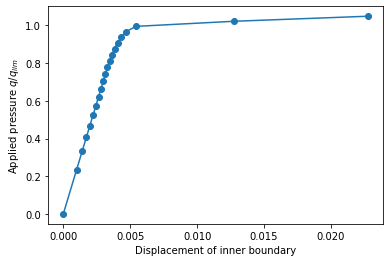

In [18]:
if len(points_on_proc) > 0:
    import matplotlib.pyplot as plt
    plt.plot(results[:, 0], results[:, 1], "-o")
    plt.xlabel("Displacement of inner boundary")
    plt.ylabel(r"Applied pressure $q/q_{lim}$")
    plt.savefig(f"displacement_rank{MPI.COMM_WORLD.rank:d}.png")
    plt.show()

In [19]:
#   Summary!!!!!
# b3 = Function(V)

# b3.x.array[:] = 0.0

# is the same as

# with b3.vector.localForm() as b_local:
#     b_local.set(0.0)

# or is the same as

# b3.vector.set(5.0)
# b3.x.scatter_forward()

In [20]:
## JAX library !